In [1]:
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import joblib

In [2]:
# import the csv as a dask dataframe

zone = "central" # north, central, or south

file_path = f'/home/evan/combinedZonesAllYears/{zone}ZoneCombined.csv'
input_dataframe = dd.read_csv(file_path)

In [4]:
#ONLY FOR NORTH - randomly sample 40% of rows in the dataframe (tested to be the max without overloading the server memory)
# uncomment if modeling north zone

#sample_frac = 0.40 
#input_dataframe = input_dataframe.sample(frac=sample_frac, random_state=42)

Accuracy: 0.9996
Precision: 0.8766


<Figure size 800x600 with 0 Axes>

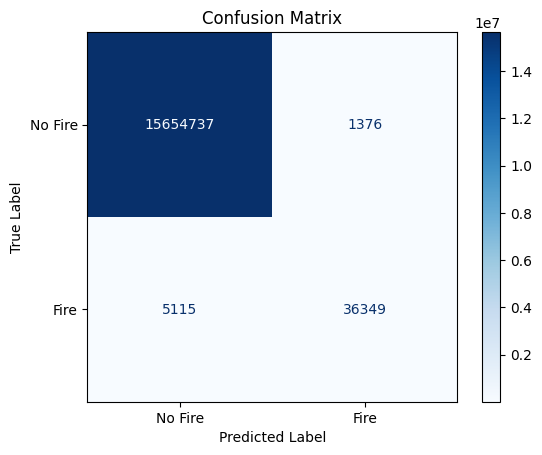

In [3]:
# random forest script
# this splits the data 80/20, trains the model, and creates a confusion matrix and prints accuracy and precision based on its prediction
# this was effective on its own for the southern and central zones (70 and 80 million rows) but not for the north (180 million rows)
# we sampled 40% of the data for the northern zone and ran this model successfully
# The accuracy for all zones is 0.999 and above but we found that this was a poor measure of effectiveness
# precision which is a measure of true positives to false negatives was a better measure of the model 
# this model had precision of 0.8 and above for all zones 

X = input_dataframe.drop(columns=['Fire', 'Date', 'Longitude', 'Latitude'])  # Adjust columns as per your dataset
y = input_dataframe['Fire']

# convert dask data frames to pandas
X_pd = X.compute()
y_pd = y.compute()

# split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=42)

# train random forest and execute with CPU multiprocessing
num_processors = 20
rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=num_processors, random_state=42)
rf_classifier.fit(X_train, y_train)

# predict on test data
y_pred = rf_classifier.predict(X_test)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# calculate accuracy 
overall_accuracy = accuracy_score(y_test, y_pred)
specific_accuracy = cm[1, 1] / cm.sum(axis=1)[1]  # true positive rate 

# print accuracy and precision
print(f'Accuracy: {overall_accuracy:.4f}')
print(f'Precision: {specific_accuracy:.4f}')

# create and print confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
#save model as a joblib file to be accessed later

joblib.dump(rf_classifier, f'{zone}AllYearsSampleForty.joblib')